# **NLP PROBLEM STATEMENT 4**

> With the tablets images fetch the required images like name of medicine, molecules in it, date of manufacturing, date of expiry. 

This notebook is dedicated to building required data and preprocessing.



In [ ]:
!pip install paddlepaddle -q
!pip install paddleocr -q

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import requests
import cv2
import numpy as np
import urllib
import pandas as pd
from google.colab.patches import cv2_imshow


> Building a web scrapper using beautiful soup  to fetch images data from netmeds.com


In [ ]:
class ScrapeTabletsImg():
  def __init__(self,required_inp_link):
    self.required_inp_link = required_inp_link
    self.list_of_product_link = []
    self.all_tablets_images = []
    self.all_downloaded_tablet_img = []

  def generate_links(self):
    req = Request(self.required_inp_link)
    html_page = urlopen(req)
    soup = BeautifulSoup(html_page, "html.parser")
    self.list_of_product_link = [link.get('href') for link in soup.find_all('a') if re.search(r"tablet|capsule", str(link.get('href')), re.IGNORECASE)]
    return self.list_of_product_link
  
  def scrape_img(self,url):
    response = Request(url)
    html_page = urlopen(response)
    soup = BeautifulSoup(html_page, 'html.parser')
    images = []
    for img in soup.find_all('img'):
      if re.search(r".(600x600).*(tablet|capsule).*", str(img.get('src')), re.IGNORECASE) and re.search(r"^(?!.*?formulation_based).*$", str(img.get('src')), re.IGNORECASE):
        images.append(img.get('src'))
    return images
  
  def download_img(self,url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
    return image
    
  def generate_tablets_img(self):
    self.generate_links()
    for link in self.list_of_product_link:
        images = self.scrape_img(link)
        if images:
            self.all_tablets_images.extend(images)

    for i in self.all_tablets_images:
      image = self.download_img(i)
      self.all_downloaded_tablet_img.append(image)
    return self.all_downloaded_tablet_img

  def display_img(self,link):
    resp = urllib.request.urlopen(link)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR) 
    cv2_imshow(image)


In [ ]:
from paddleocr import PaddleOCR,draw_ocr
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
ocr = PaddleOCR(use_angle_cls=True, lang = 'en', use_gpu = False)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:07<00:00, 516kiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer/en_PP-OCRv3_rec_infer.tar


100%|██████████| 9.96M/9.96M [00:13<00:00, 758kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:13<00:00, 165kiB/s]

[2023/02/11 19:15:53] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set

In [ ]:
def img_processing(image):
  img = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
  ## (1) Convert to gray, and threshold
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # th, threshed = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

  ## (2) Morph-op to remove noise
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

  ## (3) Find the max-area contour
  cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
  cnt = sorted(cnts, key=cv2.contourArea)[-1]

  ## (4) Crop and save it
  x,y,w,h = cv2.boundingRect(cnt)
  dst = img[y:y+h, x:x+w]

  dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
  #dst = cv2.GaussianBlur(dst,(5,5),0)
  #th, dst = cv2.threshold(dst,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  kernel = np.ones((1, 1), np.uint8)
  dst = cv2.dilate(dst, kernel, iterations=1)
  dst = cv2.erode(dst, kernel, iterations=1)

  # Create the sharpening kernel
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  # Apply the sharpening kernel to the image using filter2D
  # dst = cv2.filter2D(dst, -1, kernel)

  return dst

def takeText(img):
  ocr = PaddleOCR(use_angle_cls=True, lang = 'en', use_gpu = False)
  result = ocr.ocr(img, cls = True)[0]
  boxes = [res[0] for res in result] 
  texts = [res[1][0] for res in result]
  scores = [res[1][1] for res in result]
  return ' '.join(texts)


def run_ocr(tablets_link,tablets_img):
  Texties = {'link' : [], 'text':[]}

  for data in zip(tablets_link,tablets_img):
    link ,image  = data
    preprocessed_image = img_processing(image)
    ocr_text = takeText(preprocessed_image)
    if len(ocr_text.strip()) <= 20:
      continue
    Texties['link'].append(link)
    Texties['text'].append(ocr_text)  
  tablets = pd.DataFrame.from_dict(Texties)
  return tablets



---



In [ ]:
url = "https://www.netmeds.com/prescriptions/acne"

In [ ]:
obj = ScrapeTabletsImg(url)
tablet_imgs = obj.generate_tablets_img()


In [ ]:
acne_tablets_img = obj.all_downloaded_tablet_img
acne_tablets_link = obj.all_tablets_images

In [ ]:
len(acne_tablets_link)

300

In [ ]:
acne_text = run_ocr(acne_tablets_link,acne_tablets_img)

In [ ]:
acne_text.head()

,link,text
0,https://www.netmeds.com/images/product-v1/600x...,R Isotretinoin Capsules IP 10 mg Accufine TM 1...
1,https://www.netmeds.com/images/product-v1/600x...,NOOIEW R Isotretinoin Capsules IP 20 mg Accufi...
2,https://www.netmeds.com/images/product-v1/600x...,R Isotretinoin Capsules IP 30 mg Accufine EM 3...
3,https://www.netmeds.com/images/product-v1/600x...,R Isotretinoin Capsules IP 40 mg Accufine 40 m...
4,https://www.netmeds.com/images/product-v1/600x...,R Isotretinoin Capsules IP 5 mg Accufine TM 5 ...


In [ ]:
acne_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    249 non-null    object
 1   text    249 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [ ]:
acne_text.to_csv("acne_text_data.csv",header=True)



---

### Liver

In [ ]:
url_2 = "https://www.netmeds.com/prescriptions/liver-disease"

In [ ]:
liver = ScrapeTabletsImg(url_2)
tablet_imgs = liver.generate_tablets_img()
liver_tablets_img = liver.all_downloaded_tablet_img
liver_tablets_link = liver.all_tablets_images

In [ ]:
len(liver_tablets_img)

118

In [ ]:
liver_text = run_ocr(liver_tablets_link,liver_tablets_img)

In [ ]:
liver_text.head()

,link,text
0,https://www.netmeds.com/images/product-v1/600x...,Ademetionine Tablets 400 mg Adefresh-400 T-400...
1,https://www.netmeds.com/images/product-v1/600x...,Composition: MfgLic.No.110/UA/SC/P-2006&110/UA...
2,https://www.netmeds.com/images/product-v1/600x...,Marketednce ASCENTRA Di Ascentra 8/4Frnds Co...
3,https://www.netmeds.com/images/product-v1/600x...,SHNOWOE starta R0o Adenomnac 121% Manotactured...
4,https://www.netmeds.com/images/product-v1/600x...,Metadoxine Tablets ALCOLIV each uncoataotablet...


In [ ]:
liver_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   link    91 non-null     object
 1   text    91 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [ ]:
liver_text.to_csv("liver_text_data.csv",header=True)



---



# ***SAMPLE IMAGES WITH TEXT***

In [ ]:
sample_img_link = acne_text.loc[200].link
sample_img_ocr_text = acne_text.loc[200].text

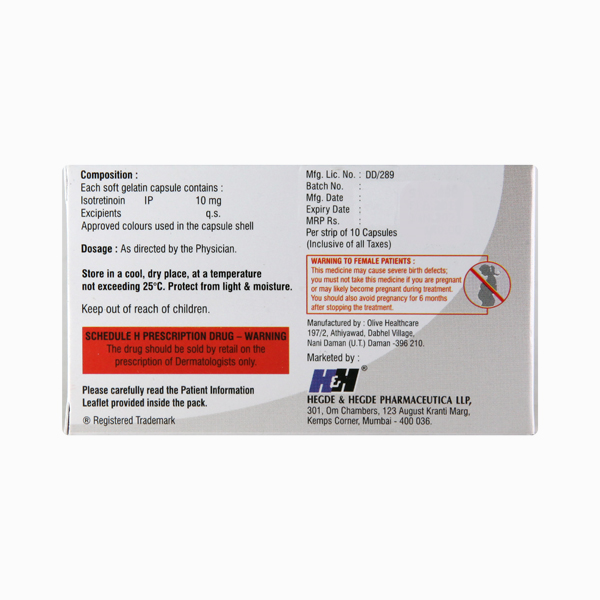

In [ ]:
sample_img = ScrapeTabletsImg(" ")
sample_img.display_img(sample_img_link)

In [ ]:
print(sample_img_ocr_text)

Composition : Mfg.Lic.No.:DD/289 Each soft gelatin capsule contains: Batch No. Isotretinoin IP 10mg Mfg.Date Excipients q.s. Expiry Date MRP Rs. Approved colours used in the capsule shell Per strip of 10 Capsules Dosage :As directed by the Physician (Inclusive of all Taxes) WARNINGTOFEMALE PATIENTS: Store in a cool,dry place,at a temperature This medicine may cause severe birth delects you must not take this meacine i you are pregnant not exceeding 25C.Protect from light & moisture cr may likely become pregnant during treatment You should also avoid pregnancy for 6 months Keep out of reach of children af ter stopping the treament Manulactured byOlive Healthcare SCHEDULEH PRESCRIPTION DRUG-WARNING 197/2,Athiyawad,Dabhel Village. The drug should be sold by retail on the Nani Daman (U.TDaman -396210 Marketed by: prescription of Dermatologists only HEH Please carefully read the Patient Informatior Leaflet provided inside the pack HEGDE &HEGDE PHARMACEUTICA LLP 301.Om Chambers.123 August Kr

*Composition : Mfg.Lic.No.:DD/289 Each soft gelatin capsule contains: Batch No. Isotretinoin IP 10mg Mfg.Date Excipients q.s. Expiry Date MRP Rs. Approved colours used in the capsule shell Per strip of 10 Capsules Dosage :As directed by the Physician (Inclusive of all Taxes) WARNINGTOFEMALE PATIENTS: Store in a cool,dry place,at a temperature This medicine may cause severe birth delects you must not take this meacine i you are pregnant not exceeding 25C.Protect from light & moisture cr may likely become pregnant during treatment You should also avoid pregnancy for 6 months Keep out of reach of children af ter stopping the treament Manulactured byOlive Healthcare SCHEDULEH PRESCRIPTION DRUG-WARNING 197/2,Athiyawad,Dabhel Village. The drug should be sold by retail on the Nani Daman (U.TDaman -396210 Marketed by: prescription of Dermatologists only HEH Please carefully read the Patient Informatior Leaflet provided inside the pack HEGDE &HEGDE PHARMACEUTICA LLP 301.Om Chambers.123 August Kranti Marg Registered Trademark Kemps Corner.Murmbai-400036*